# ANT COLONY ALGORITHM FOR RANDOM DATA

Iteration 1 - Best Path Length: 1657.64
Iteration 2 - Best Path Length: 1464.14
Iteration 3 - Best Path Length: 1464.14
Iteration 4 - Best Path Length: 1464.14
Iteration 5 - Best Path Length: 1399.79
Iteration 6 - Best Path Length: 1386.64
Iteration 7 - Best Path Length: 1386.64
Iteration 8 - Best Path Length: 1386.64
Iteration 9 - Best Path Length: 1359.16
Iteration 10 - Best Path Length: 1318.52


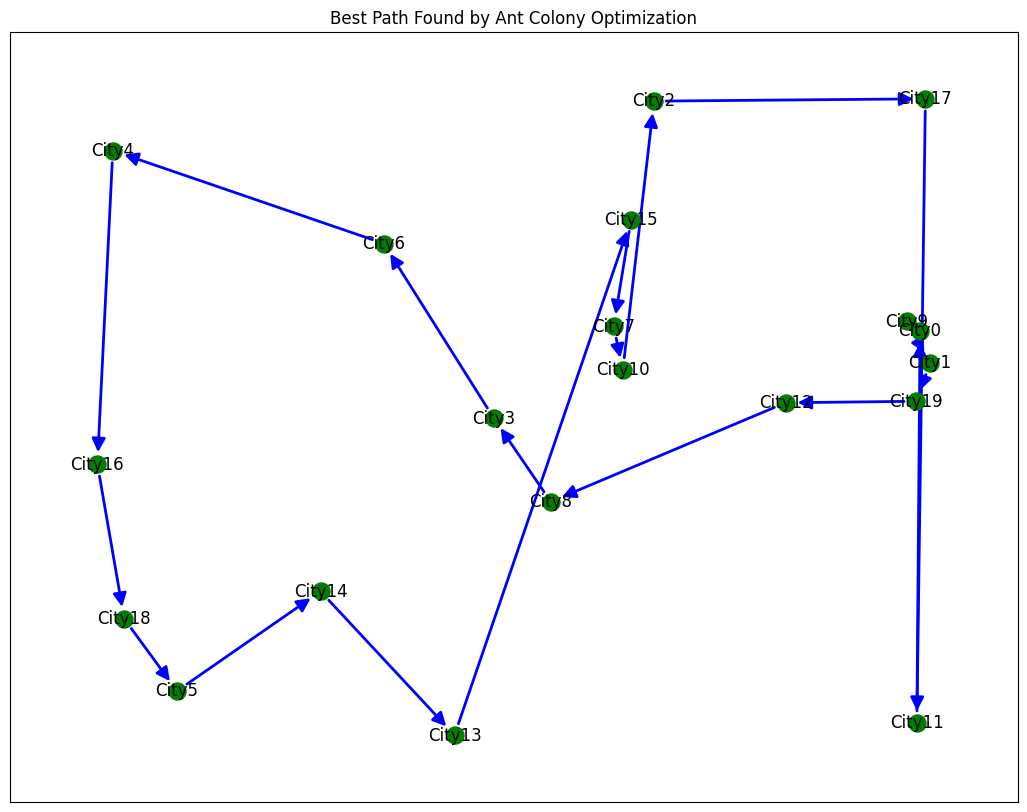

Best Path: ['City0', 'City9', 'City1', 'City19', 'City12', 'City8', 'City3', 'City6', 'City4', 'City16', 'City18', 'City5', 'City14', 'City13', 'City15', 'City7', 'City10', 'City2', 'City17', 'City11', 'City0']
Best Path Length: 1318.5193138318973
Execution Time: 0.19 seconds


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from datetime import datetime

# Generate random cities (latitude, longitude)
n_cities = 20
cities = [("City" + str(i), np.random.uniform(-90, 90), np.random.uniform(-180, 180)) for i in range(n_cities)]

# Convert city coordinates to a numpy array
points = np.array([(lon, lat) for _, lat, lon in cities])

# Vectorized function to calculate the Euclidean distance matrix
def distance_matrix(points):
    diff = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    return np.linalg.norm(diff, axis=2)

def generate_traffic_factors(n_points):
    traffic_morning = np.random.rand(n_points, n_points)  # Traffic factor for 00:00 - 12:00
    traffic_evening = np.random.rand(n_points, n_points)  # Traffic factor for 12:00 - 00:00
    return traffic_morning, traffic_evening

def get_current_traffic_factor(traffic_morning, traffic_evening):
    current_hour = datetime.now().hour
    if 0 <= current_hour < 12:
        return traffic_morning
    else:
        return traffic_evening

def is_feasible_tour(current_tour, next_node, demands, vehicle_capacity):
    total_demand = sum(demands[i] for i in current_tour) + demands[next_node]
    return total_demand <= vehicle_capacity

# Ant Colony Optimization algorithm with improved efficiency
def ant_colony_optimization(points, n_ants, n_iterations, alpha, beta, evaporation_rate, Q):
    n_points = len(points)
    pheromone = np.ones((n_points, n_points))  # Initial pheromone levels
    best_path = None
    best_path_length = np.inf
    
    # Vehicle capacity
    vehicle_capacity = 500

    # Demand at each node (example demands, including depot with 0 demand)
    demands = np.random.randint(1, 10, size=n_points - 1)
    demands = np.insert(demands, 0, 0)  # Insert 0 demand for the depot
    
    # Calculate the distance matrix using vectorization
    dist_matrix = distance_matrix(points)
    
    # Generate traffic factors
    traffic_morning, traffic_evening = generate_traffic_factors(n_points)
    
    for iteration in range(n_iterations):
        paths = []
        path_lengths = []
        
        for ant in range(n_ants):
            visited = np.zeros(n_points, dtype=bool)
            current_point = 0  # Starting at node 0
            path = [current_point]
            path_length = 0
            visited[current_point] = True
            
            while np.sum(visited) < n_points:
                unvisited = ~visited
                pheromones = pheromone[current_point, unvisited]
                distances = dist_matrix[current_point, unvisited]
                probabilities = pheromones ** alpha * (1.0 / distances) ** beta
                probabilities /= probabilities.sum()
                
                # Select feasible candidates
                candidates = np.where(unvisited)[0]
                feasible_candidates = [c for c in candidates if is_feasible_tour(path, c, demands, vehicle_capacity)]
                
                if not feasible_candidates:  # No feasible node found
                    break
                
                # Ensure we are only indexing the probabilities with valid indices
                feasible_indices = [candidates.tolist().index(fc) for fc in feasible_candidates]
                feasible_probabilities = probabilities[feasible_indices]
                feasible_probabilities /= feasible_probabilities.sum()  # Normalize probabilities to sum to 1

                next_point = np.random.choice(feasible_candidates, p=feasible_probabilities)
                
                path.append(next_point)
                path_length += dist_matrix[current_point, next_point]
                visited[next_point] = True
                current_point = next_point
            
            # Returning to the starting point to complete the cycle
            path_length += dist_matrix[current_point, path[0]]
            path.append(path[0])
            
            paths.append(path)
            path_lengths.append(path_length)
            
            if path_length < best_path_length:
                best_path = path
                best_path_length = path_length
        
        # Get the current traffic factor
        current_traffic_factor = get_current_traffic_factor(traffic_morning, traffic_evening)
        
        # Pheromone evaporation with traffic factor
        for i in range(n_points):
            for j in range(n_points):
                pheromone[i, j] *= evaporation_rate * current_traffic_factor[i, j]
                
        # Pheromone update
        for path, path_length in zip(paths, path_lengths):
            for i in range(len(path) - 1):
                pheromone[path[i], path[i+1]] += Q / path_length

        # Print best path length for each iteration
        print(f"Iteration {iteration + 1} - Best Path Length: {best_path_length:.2f}")

    # Graph visualization for the last iteration
    plt.figure(figsize=(13, 10))
    G = nx.DiGraph()
    pos = {i: points[i] for i in range(n_points)}
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            G.add_edge(i, j)
    
    nx.draw_networkx_nodes(G, pos, node_color='green', node_size=150)
    nx.draw_networkx_labels(G, pos, labels={i: cities[i][0] for i in range(n_points)})
    if best_path:
        edges = [(best_path[i], best_path[i + 1]) for i in range(len(best_path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='blue', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)
    
    plt.title(f'Best Path Found by Ant Colony Optimization')
    plt.show()

    # Print best path and its length for the last iteration
    if best_path:
        best_city_path = [cities[i][0] for i in best_path]
        print("Best Path:", best_city_path)
        print("Best Path Length:", best_path_length)

# Example usage
np.random.seed(0)  # For reproducibility
start_time = time.time()  # Start the timer
ant_colony_optimization(points, n_ants=10, n_iterations=10, alpha=1, beta=2, evaporation_rate=0.5, Q=100)
end_time = time.time()  # End the timer
execution_time = end_time - start_time  # Calculate the execution time
print(f"Execution Time: {execution_time:.2f} seconds")


# ANT COLONY ALGORITHM FOR DEFINED CITIES

Iteration 1 - Best Path Length: 45.46
Iteration 2 - Best Path Length: 45.46
Iteration 3 - Best Path Length: 42.38
Iteration 4 - Best Path Length: 40.88
Iteration 5 - Best Path Length: 40.88
Iteration 6 - Best Path Length: 37.41
Iteration 7 - Best Path Length: 37.41
Iteration 8 - Best Path Length: 37.41
Iteration 9 - Best Path Length: 37.41
Iteration 10 - Best Path Length: 37.41


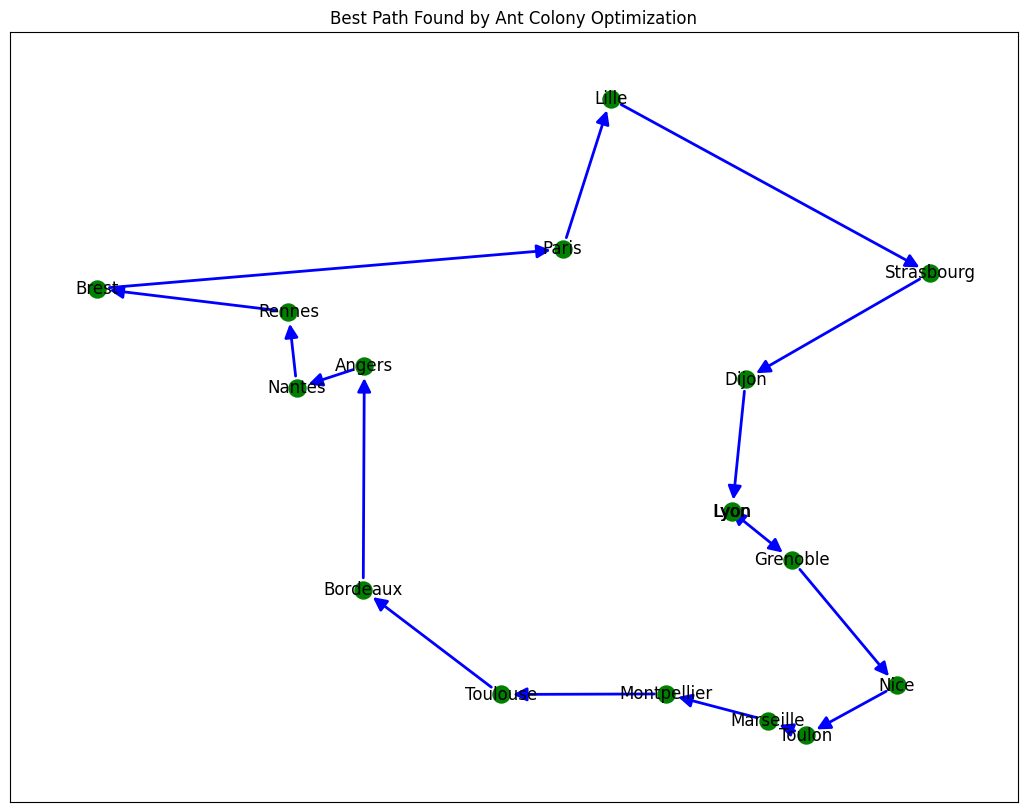

Best Path: ['Paris', 'Lille', 'Strasbourg', 'Dijon', 'Lyon', 'Lyon', 'Grenoble', 'Nice', 'Toulon', 'Marseille', 'Montpellier', 'Toulouse', 'Bordeaux', 'Angers', 'Nantes', 'Rennes', 'Brest', 'Paris']
Best Path Length: 37.40985809707772
Execution Time: 0.19 seconds


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from datetime import datetime

# Coordinates for the 20 most populated cities in France (latitude, longitude)
cities = [
    ("Paris", 48.8566, 2.3522),
    ("Marseille", 43.2965, 5.3698),
    ("Lyon", 45.7640, 4.8357),
    ("Toulouse", 43.6045, 1.4442),
    ("Nice", 43.7102, 7.2620),
    ("Nantes", 47.2184, -1.5536),
    ("Strasbourg", 48.5734, 7.7521),
    ("Montpellier", 43.6108, 3.8767),
    ("Bordeaux", 44.8378, -0.5792),
    ("Lille", 50.6292, 3.0573),
    ("Rennes", 48.1173, -1.6778),     
    ("Angers", 47.4784, -0.5632),
    ("Grenoble", 45.1885, 5.7245),
    ("Dijon", 47.3220, 5.0415),
    ("Brest", 48.3904, -4.4861),
    ("Lyon", 45.7597, 4.8422),
    ("Toulon", 43.1242, 5.9280),
]

# Convert city coordinates to a numpy array
points = np.array([(lon, lat) for _, lat, lon in cities])

# Vectorized function to calculate the Euclidean distance matrix
def distance_matrix(points):
    diff = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    return np.linalg.norm(diff, axis=2)

def generate_traffic_factors(n_points):
    traffic_morning = np.random.rand(n_points, n_points)  # Traffic factor for 00:00 - 12:00
    traffic_evening = np.random.rand(n_points, n_points)  # Traffic factor for 12:00 - 00:00
    return traffic_morning, traffic_evening

def get_current_traffic_factor(traffic_morning, traffic_evening):
    current_hour = datetime.now().hour
    if 0 <= current_hour < 12:
        return traffic_morning
    else:
        return traffic_evening

def is_feasible_tour(current_tour, next_node, demands, vehicle_capacity):
    total_demand = sum(demands[i] for i in current_tour) + demands[next_node]
    return total_demand <= vehicle_capacity

# Ant Colony Optimization algorithm with improved efficiency
def ant_colony_optimization(points, n_ants, n_iterations, alpha, beta, evaporation_rate, Q):
    n_points = len(points)
    pheromone = np.ones((n_points, n_points))  # Initial pheromone levels
    best_path = None
    best_path_length = np.inf
    
    # Vehicle capacity
    vehicle_capacity = 500

    # Demand at each node (example demands, including depot with 0 demand)
    demands = np.random.randint(1, 10, size=n_points - 1)
    demands = np.insert(demands, 0, 0)  # Insert 0 demand for the depot
    
    # Calculate the distance matrix using vectorization
    dist_matrix = distance_matrix(points)
    
    # Generate traffic factors
    traffic_morning, traffic_evening = generate_traffic_factors(n_points)
    
    for iteration in range(n_iterations):
        paths = []
        path_lengths = []
        
        for ant in range(n_ants):
            visited = np.zeros(n_points, dtype=bool)
            current_point = 0  # Starting at node 0
            path = [current_point]
            path_length = 0
            visited[current_point] = True
            
            while np.sum(visited) < n_points:
                unvisited = ~visited
                pheromones = pheromone[current_point, unvisited]
                distances = dist_matrix[current_point, unvisited]
                probabilities = pheromones ** alpha * (1.0 / distances) ** beta
                probabilities /= probabilities.sum()
                
                # Select feasible candidates
                candidates = np.where(unvisited)[0]
                feasible_candidates = [c for c in candidates if is_feasible_tour(path, c, demands, vehicle_capacity)]
                
                if not feasible_candidates:  # No feasible node found
                    break
                
                # Ensure we are only indexing the probabilities with valid indices
                feasible_indices = [candidates.tolist().index(fc) for fc in feasible_candidates]
                feasible_probabilities = probabilities[feasible_indices]
                feasible_probabilities /= feasible_probabilities.sum()  # Normalize probabilities to sum to 1

                next_point = np.random.choice(feasible_candidates, p=feasible_probabilities)
                
                path.append(next_point)
                path_length += dist_matrix[current_point, next_point]
                visited[next_point] = True
                current_point = next_point
            
            # Returning to the starting point to complete the cycle
            path_length += dist_matrix[current_point, path[0]]
            path.append(path[0])
            
            paths.append(path)
            path_lengths.append(path_length)
            
            if path_length < best_path_length:
                best_path = path
                best_path_length = path_length
        
        # Get the current traffic factor
        current_traffic_factor = get_current_traffic_factor(traffic_morning, traffic_evening)
        
        # Pheromone evaporation with traffic factor
        for i in range(n_points):
            for j in range(n_points):
                pheromone[i, j] *= evaporation_rate * current_traffic_factor[i, j]
                
        # Pheromone update
        for path, path_length in zip(paths, path_lengths):
            for i in range(len(path) - 1):
                pheromone[path[i], path[i+1]] += Q / path_length

        # Print best path length for each iteration
        print(f"Iteration {iteration + 1} - Best Path Length: {best_path_length:.2f}")

    # Graph visualization for the last iteration
    plt.figure(figsize=(13, 10))
    G = nx.DiGraph()
    pos = {i: points[i] for i in range(n_points)}
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            G.add_edge(i, j)
    
    nx.draw_networkx_nodes(G, pos, node_color='green', node_size=150)
    nx.draw_networkx_labels(G, pos, labels={i: cities[i][0] for i in range(n_points)})
    if best_path:
        edges = [(best_path[i], best_path[i + 1]) for i in range(len(best_path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='blue', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)
    
    plt.title(f'Best Path Found by Ant Colony Optimization')
    plt.show()

    # Print best path and its length for the last iteration
    if best_path:
        best_city_path = [cities[i][0] for i in best_path]
        print("Best Path:", best_city_path)
        print("Best Path Length:", best_path_length)

# Example usage
np.random.seed(0)  # For reproducibility
start_time = time.time()  # Start the timer
ant_colony_optimization(points, n_ants=10, n_iterations=10, alpha=1, beta=2, evaporation_rate=0.5, Q=100)
end_time = time.time()  # End the timer
execution_time = end_time - start_time  # Calculate the execution time
print(f"Execution Time: {execution_time:.2f} seconds")
